In [1]:
import scipy
from scipy.fft import dct, idct
import numpy as np
from numpy.linalg import norm, inv
from matplotlib import pyplot as plt
from scipy.optimize import linprog

In [2]:
data = np.genfromtxt("nile.csv", delimiter=",", skip_header=1)
data.shape

(100, 2)

In [3]:
f = data[:,1]
f.shape

(100,)

In [4]:
X = scipy.fft.dct(np.identity(f.shape[0]), norm='ortho')
X.shape

(100, 100)

In [5]:
indices = [i for i in range(25, 75, 5)]
len(indices)

10

In [6]:
# remove some values in the middle
f_I = np.delete(data, indices, axis=0)[:,1]
f_I.shape

(90,)

In [7]:
X_I = np.delete(X, indices, axis=0)
X_I.shape

(90, 100)

# Question 1

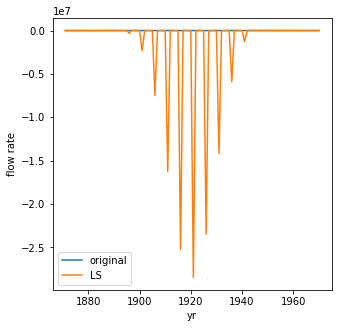

In [8]:
# standard
a = inv(X_I.T@X_I)@X_I.T@f_I
f = X@a

fig = plt.figure(figsize = (5,5))
plt.plot(data[:, 0], data[:, 1], label="original")
plt.plot(data[:, 0], f, label="LS")
plt.xlabel('yr')
plt.ylabel('flow rate')
plt.legend()
plt.show()

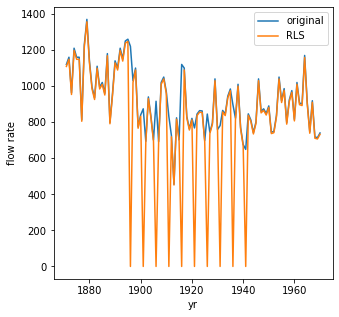

In [9]:
# regular
# the sigma is already tuned to make the predicted signals to get relatively the closest to the original

sigma = 0.01
a = inv(X_I.T@X_I + sigma*np.identity(X_I.T.shape[0]))@X_I.T@f_I
f = X@a

fig = plt.figure(figsize = (5,5))
plt.plot(data[:, 0], data[:, 1], label="original")
plt.plot(data[:, 0], f, label="RLS")
plt.xlabel('yr')
plt.ylabel('flow rate')
plt.legend()
plt.show()

Standard l2 does not do a good job filling the data. and the regularized one is only able to recover the unmissing signals, and makes the missing one zero. 

Specific explanation see question 1 in pdf

# Question 2

In [10]:
A_eq = np.concatenate((X_I, -X_I), axis=1)
c = np.ones(A_eq.shape[1])
b_eq = f_I
s = linprog(c=c,A_eq=A_eq,b_eq=b_eq,bounds=tuple((0,None) for _ in range(c.shape[0])))

In [11]:
# reconstruct a
a = s.x[0:100] - s.x[100:200]
a.shape
f = X@a

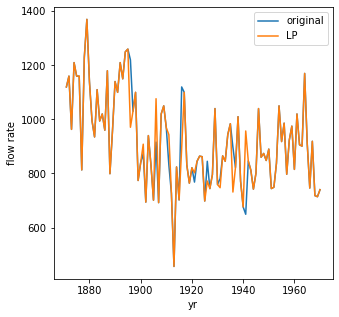

In [12]:
fig = plt.figure(figsize = (5,5))
plt.plot(data[:, 0], data[:, 1], label="original")
plt.plot(data[:, 0], f, label="LP")
plt.xlabel('yr')
plt.ylabel('flow rate')
plt.legend()
plt.show()

# Question 4

In [13]:
A_ub = np.concatenate((X_I.T, -X_I.T), axis=0)
c = -f_I
b_ub = np.ones(A_ub.shape[0])
s = linprog(c=c,A_ub=A_ub,b_ub=b_ub,bounds=tuple((None,None) for _ in range(c.shape[0])))

In [14]:
print(s.x.shape)
print(s.slack.shape)

(90,)
(200,)


In [15]:
# count zeros in 1d array
nonzero_x_entries = np.where(s.slack<=1e-7)[0]
# zeros of slack variable, meaning 90 nonzeros for the 200 entries x = (u,v)
# we know [X_I -X_I] x = b, now we can reduce 90*200 A = [X_I -X_I] to A' = 90 * 90

A = np.concatenate((X_I, -X_I), axis=1)
A_p = A[:,nonzero_x_entries]
A_p.shape
nonzero_x = inv(A_p)@f_I
x = np.zeros(200)
x[nonzero_x_entries] = nonzero_x

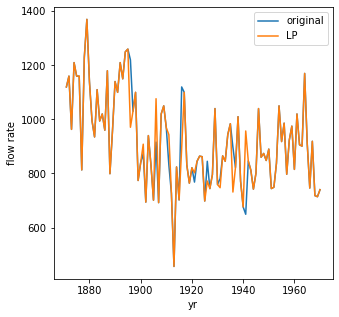

In [16]:
# reconstruct a
a = x[0:100] - x[100:200]
a.shape
f = X@a
fig = plt.figure(figsize = (5,5))
plt.plot(data[:, 0], data[:, 1], label="original")
plt.plot(data[:, 0], f, label="LP")
plt.xlabel('yr')
plt.ylabel('flow rate')
plt.legend()
plt.show()

The result from graph agrees with 2